# LAB 5. CONSTRAINED OPTIMIZATION: EQUALITY AND INEQUALITY CONSTRAINTS 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from QPGC import QPGenericConstraints

In [2]:
help(QPGenericConstraints)

Help on function QPGenericConstraints in module QPGC:

QPGenericConstraints(G, g, A, C, b, d)
    Convex optimization problem with equality and inequality constraints:
     
               min f(x)=1/2 x^T G X + g^T x     s.t.   A^T x = b i C^T x >= d
    
    Call it with:
    
    x = QPGenericConstrains(G, g, A, C, b, d)
    
    Notation:
    
    n = number of variables
    p = number of equality constants
    m = number of inequality constants
     
    Dimensions:   G -> n x n
                  g -> n x 1
                  A -> n x p
                  C -> n x m
                  b -> p x 1  
                  d -> m x 1



In [3]:
def generate_sample(m1, s1, m2, s2, n_samples, row_format=False):  # n_samples = m
    n_samples_class = n_samples // 2
    
    X_positive = np.random.multivariate_normal(m1, s1, n_samples_class)
    X_negative = np.random.multivariate_normal(m2, s2, n_samples_class)
    
    if row_format:
        X = np.hstack([X_positive.T, X_negative.T])
    else:
        X = np.vstack([X_positive, X_negative])
    
    y = np.r_[np.ones(n_samples_class), -np.ones(n_samples_class)]
    
    return X, y

In [4]:
def plot_sample(X, y, w=None, b=None, row_format=False):
    cdict = {1: 'red', -1: 'blue'}
    
    for c in np.unique(y):
        idx = np.where(y == c)

        x_coords = X[0, idx] if row_format else X[idx, 0]
        y_coords = X[1, idx] if row_format else X[idx, 1]

        plt.scatter(x_coords, y_coords, c=cdict[c], label=int(c))

    if w is not None and b is not None:
        # Compute min and max values for x-axis
        x_axis_vals = X[0, :] if row_format else X[:, 0]
        min_x = np.min(x_axis_vals)
        max_x = np.max(x_axis_vals)
        
        x_values = np.arange(min_x, max_x, 0.1)
        line = x_values * w[0] + b

        plt.plot(x_values, -line / w[1], 'k')
        plt.plot(x_values, (-line + 1) / w[1], 'k--')
        plt.plot(x_values, (-line - 1) / w[1], 'k--')

    plt.legend()
    plt.show()

In [5]:
def create_dual_formulation(X, y, n_samples, K=1):
    Y = np.diagflat(y)
    identity_mat = np.eye(n_samples)
    ones = np.ones(n_samples)
    
    G = np.dot(Y, np.dot(X.T, np.dot(X, Y)))
    g = -ones
    A = y.reshape(-1, 1)
    C = np.hstack([identity_mat, -identity_mat])
    b = np.zeros(1)
    d = np.r_[np.zeros(n_samples), -K * ones]
    
    return G, g, A, C, b, d


def svm_dual_space(X, y, n_samples, K=1, plot_results=True):
    # Create the data for the formulation in the dual space
    G, g, A, C, b, d = create_dual_formulation(X, y, n_samples)
    
    # Solve the problem and get the \alpha values
    alpha = QPGenericConstraints(G, g, A, C, b, d)
    
    # Get the hyperplane and the bias
    w = np.dot(alpha * y, X.T)
    idx = np.where(alpha > 1e-10)[0]
    
    b = np.mean(y[idx] - np.dot(w, X[:, idx]))
    
    if plot_results:
        plot_sample(X, y, w, b, row_format=True)
    
    return w, b

In [6]:
m1 = [0.,0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2sep = [3., 6.]
s2sep = [[1, 0], [0, 1]]
m2nsep = [1., 2.]
s2nsep = s2sep

## SIMPLE CASE

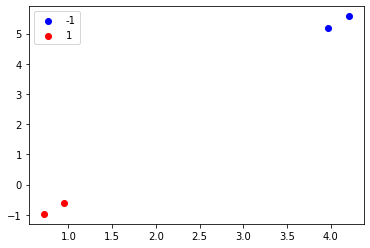

In [7]:
n_samples = 4
K = 1

X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

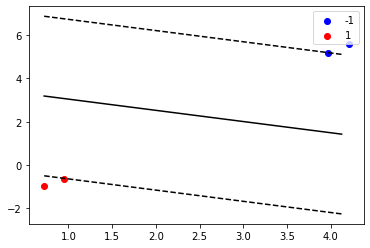

w: [-0.14054848 -0.27148773]	b: 0.9670626412126075


In [8]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

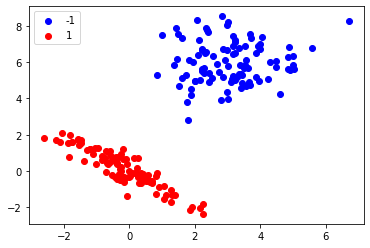

In [9]:
n_samples = 200
X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples, row_format=True)
plot_sample(X, y, row_format=True)

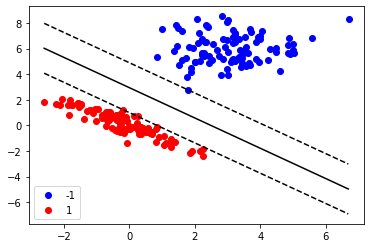

w: [-0.60661731 -0.5129195 ]	b: 1.50920609700243


In [10]:
w, b = svm_dual_space(X, y, n_samples)
print(f'w: {w}\tb: {b}')

# LAB 6: STOCHASTIC GRADIENT DESCENT FOR SVM

In [11]:
def f(X, y, lamb, w, b):
    return 0.5 * lamb * np.dot(w, w) + np.sum(np.maximum(0, 1 - y * (np.dot(X, w) + b)))


def stochastic_gradient_descent(X, y, n_epochs=500, mu_0=100, mu_increment=0.1, lamb=1e-4, batch_size=10):
    n_samples = X.shape[0]
    mu = mu_0
    
    # Declare parameters
    w = np.array([1., 1.])
    b = 0
    
    log_f_values = [np.log(f(X, y, lamb, w, b))]
    
    for j in range(n_epochs):
        shuffle_idx = np.random.permutation(np.arange(n_samples))
        X_shuffled, y_shuffled = X[shuffle_idx], y[shuffle_idx]
                
        for i in range(0, n_samples, batch_size):
            gamma = 1 / mu

            X_mini_batch, y_mini_batch = X_shuffled[i:i+batch_size], y_shuffled[i:i+batch_size]
            
            mask = y_mini_batch * (np.dot(X_mini_batch, w) + b) <= 1
            
            # y needs to be transformed so that the element wise multiplication
            # with the elements of the batch can be performed            
            w = w - gamma * (lamb * w + np.sum(-y_mini_batch[mask, np.newaxis] * X_mini_batch[mask], axis=0))
            b = b - gamma * np.sum(-y_mini_batch[mask])
            
            mu += mu_increment
        
        log_f_values.append(np.log(f(X, y, lamb, w, b)))

    
    return w, b, np.array(log_f_values)

In [12]:
m1 = [0.,0.]
s1 = [[1, -0.9], [-0.9, 1]]
m2sep = [3., 6.]
s2sep = [[1, 0], [0, 1]]
m2nsep = [1., 2.]
s2nsep = s2sep

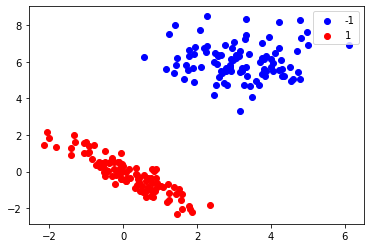

In [13]:
n_samples = 200

X, y = generate_sample(m1, s1, m2sep, s2sep, n_samples)
plot_sample(X, y)

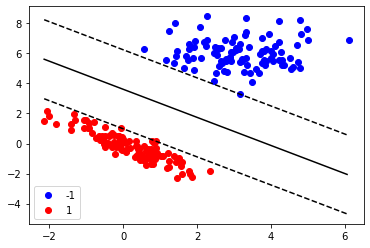

In [14]:
w, b, log_f_values_1 = stochastic_gradient_descent(X, y, batch_size=1, n_epochs=2000)
plot_sample(X, y, w, b)

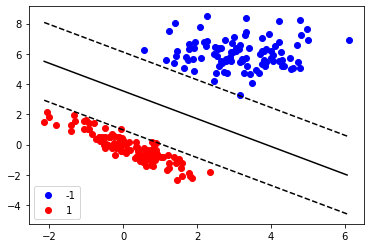

In [15]:
w, b, log_f_values_20 = stochastic_gradient_descent(X, y, batch_size=20, n_epochs=2000)
plot_sample(X, y, w, b)

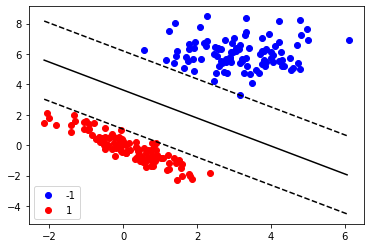

In [16]:
w, b, log_f_values_200 = stochastic_gradient_descent(X, y, batch_size=200, n_epochs=2000, lamb=1, mu_increment=0.01)
plot_sample(X, y, w, b)

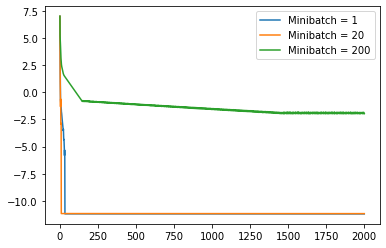

In [17]:
plt.plot(np.arange(len(log_f_values_1)), log_f_values_1, label='Minibatch = 1')
plt.plot(np.arange(len(log_f_values_20)), log_f_values_20, label='Minibatch = 20')
plt.plot(np.arange(len(log_f_values_200)), log_f_values_200, label='Minibatch = 200')

plt.legend()
plt.show()